# Inverse Optimization for DFS
_Applying Ghobadi and Mahmoudzadeh 2021_

In [1]:
using JuMP
using Gurobi
using LinearAlgebra
using Distributions
using Random

Random.seed!(42)

TaskLocalRNG()

In [2]:
include("dflio.jl")

import .DflIo.Forward as Forward
import .DflIo.InverseDemand as IODemand
import .DflIo.InverseLinReg as IOLinReg
import .DflIo.DataGeneration as DataGen

## Forward problem

In [3]:
function forward_example_params()::Forward.Params
    enabled_flows = ones(Bool, (2, 2))
    enabled_flows[1, 2] = false

    return Forward.Params(
        n_paths=2, 
        n_commodities=2,
        capacities=[100, 100],
        design_costs=[100, 10],
        flow_costs=[10 10 ; 100 100],
        enabled_flows=enabled_flows
    )
end

function forward_example_demand()::Vector
    return [10, 6]
end

forward_example_demand (generic function with 1 method)

In [4]:
forward_params = forward_example_params()
forward_demand = forward_example_demand()

forward_sol = Forward.create_and_solve_problem(forward_params, forward_demand)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-04-23
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel(R) Core(TM) i5-8250U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 5 rows, 6 columns and 11 nonzeros
Model fingerprint: 0xa664e8a1
Variable types: 4 continuous, 2 integer (2 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+01, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e+00, 1e+01]
Presolve removed 5 rows and 6 columns
Presolve time: 0.01s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 1: 810 

Optimal solution found (tolerance 1.00e-04)
Best objective 8.100000000000e+02, best bound 8.100000000000e+02, gap 0.0000%

User-callback calls 21

Main.DflIo.Forward.Solution([10.0 0.0; 0.0 6.0], [1.0, 1.0])

In [5]:
println(forward_sol.x_sol)
println(forward_sol.z_sol)

[10.0 0.0; 0.0 6.0]


[1.0, 1.0]


## Inverse problem

### Demand only

In [6]:
inverse_demand_model = IODemand.create_problem(forward_params, forward_sol)
print(inverse_demand_model)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-04-23
Tuple{Main.DflIo.Forward.Solution}Feasibility


Subject to
 

b[1] + b[3] = 0.0
 b[2] + b[4] = 0.0
 -b[1] ≥ -10.0
 -b[2] ≥ -6.0
 -b[3] ≥ 10.0
 -b[4] ≥ 6.0


In [7]:
inverse_demand_solution = IODemand.solve_problem!(inverse_demand_model)

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel(R) Core(TM) i5-8250U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 6 rows, 4 columns and 8 nonzeros
Model fingerprint: 0x6dbc1eae
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e+00, 1e+01]
Presolve removed 6 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective  0.000000000e+00

User-callback calls 31, time in user-callback 0.00 sec


Main.DflIo.InverseDemand.Solution([10.0, 6.0])

In [8]:
print(inverse_demand_solution)

Main.DflIo.InverseDemand.Solution([10.0, 6.0])

### Linear regression without noise

In [9]:
function inverse_linreg_example_datagen_params()
    return DataGen.DataGenParams(weights=[1.5 2; 1 1])
end

function inverse_linreg_example_problem_params()
    return IOLinReg.Params(n_features=2, forward_params=forward_example_params())
end

function inverse_linreg_example_featuress()
    return [[4, 2], [3, 1]]
end

inverse_linreg_example_featuress (generic function with 1 method)

In [10]:
datagen_params = inverse_linreg_example_datagen_params()
problem_params = inverse_linreg_example_problem_params()
input_featuress = inverse_linreg_example_featuress()

solutions = DataGen.generate_solution_points(datagen_params, problem_params, input_featuress)

[[4, 2], [3, 1]]Set parameter Username
Academic license - for non-commercial use only - expires 2024-04-23
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel(R) Core(TM) i5-8250U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 5 rows, 6 columns and 11 nonzeros
Model fingerprint: 0xa664e8a1
Variable types: 4 continuous, 2 integer (2 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+01, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e+00, 1e+01]
Presolve removed 5 rows and 6 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.00 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 1: 810 

Optimal solution found (tolerance 1.00e-04)
Best objective 8.100000000000e+02, best bound 8.100000000000e+02, gap 0.0000%

User-c

2-element Vector{Main.DflIo.InverseLinReg.SolutionPoint}:
 Main.DflIo.InverseLinReg.SolutionPoint(Main.DflIo.Forward.Solution([10.0 0.0; 0.0 6.0], [1.0, 1.0]), [4.0, 2.0])
 Main.DflIo.InverseLinReg.SolutionPoint(Main.DflIo.Forward.Solution([6.5 0.0; 0.0 4.0], [1.0, 1.0]), [3.0, 1.0])

In [11]:
linreg_model = IOLinReg.create_problem(problem_params, solutions)
print(linreg_model)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-04-23
1 AT GenericAffExpr{Number, VariableRef}[1, 1, 0, 0, 0, 0, w[1,1], w[1,2]]


2 AT GenericAffExpr{Number, VariableRef}[0, 0, 0, 1, 0, 0, w[2,1], w[2,2]]
3 AT GenericAffExpr{Number, VariableRef}[-1, -1, 0, 0, 0, 0, -w[1,1], -w[1,2]]
4 AT GenericAffExpr{Number, VariableRef}[0, 0, 0, -1, 0, 0, -w[2,1], -w[2,2]]
1 AT GenericAffExpr{Number, VariableRef}[1, 1, 0, 0, 0, 0, w[1,1], w[1,2]]
2 AT GenericAffExpr{Number, VariableRef}[0, 0, 0, 1, 0, 0, w[2,1], w[2,2]]
3 AT GenericAffExpr{Number, VariableRef}[-1, -1, 0, 0, 0, 0, -w[1,1], -w[1,2]]
4 AT GenericAffExpr{Number, VariableRef}[0, 0, 0, -1, 0, 0, -w[2,1], -w[2,2]]
Feasibility
Subject to
 4 w[1,1] + 2 w[1,2] ≥ -10.0
 4 w[2,1] + 2 w[2,2] ≥ -6.0
 -4 w[1,1] - 2 w[1,2] ≥ 10.0
 -4 w[2,1] - 2 w[2,2] ≥ 6.0
 3 w[1,1] + w[1,2] ≥ -6.5
 3 w[2,1] + w[2,2] ≥ -4.0
 -3 w[1,1] - w[1,2] ≥ 6.5
 -3 w[2,1] - w[2,2] ≥ 4.0


In [12]:
linreg_solution = IOLinReg.solve_problem!(linreg_model)
print(linreg_solution)

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel(R) Core(TM) i5-8250U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 8 rows, 4 columns and 16 nonzeros
Model fingerprint: 0x33b36c77
Coefficient statistics:
  Matrix range     [1e+00, 4e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+00, 1e+01]
Presolve removed 8 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective  0.000000000e+00

User-callback calls 49, time in user-callback 0.00 sec
Main.DflIo.InverseLinReg.Solution([1.5 2.0; 1.0 1.0])

### Linear regression with noise 

In [13]:
function noisy_example_datagen_params()
    return DataGen.DataGenParams(weights=[1.5 2; 1 1], noise_variance=[1.2, 0.8])
end

function noisy_example_problem_params()
    return IOLinReg.Params(n_features=2, forward_params=forward_example_params(), with_noise=true)
end

function noisy_example_featuress(n_points::Integer)
    n_features = 2

    uniform = Uniform.(zeros(n_features), 10 .* ones(n_features))
    mv_uniform = Product(uniform)
    
    points = rand(mv_uniform, n_points)
    
    return [points[:, col] for col in 1:size(points)[2]]
end

noisy_example_featuress (generic function with 1 method)

In [14]:
noisy_datagen_params = noisy_example_datagen_params()
noisy_problem_params = noisy_example_problem_params()
noisy_input_featuress = noisy_example_featuress(30)

solutions = DataGen.generate_solution_points(noisy_datagen_params, noisy_problem_params, noisy_input_featuress)

[[6.293451231426089, 4.503389405961936], [4.774071434328178, 7.031298490032015], [6.733461456394963, 1.6589443479313404], [6.134782250008442, 6.683403279577278], [4.570310908017041, 2.993652953937611], [6.611433726193705, 6.3943136204234925], [3.4264792290134793, 2.678704383989201], [5.15871408349502, 0.9002301604339691], [2.7265744579429385, 1.9156220259693801], [4.2359125647259885, 4.847023673932017], [0.8057685880656873, 5.1535136650952795], [1.9650886681273116, 6.005123652935154], [3.9770669886798293, 3.159294604248214], [4.341268471846975, 8.586747334564407], [3.196316787127417, 5.636653686397767], [3.2191019229275106, 1.5791906602724803], [7.2198273504068435, 3.7234662933043774], [0.30185550039208087, 0.7933388944734077], [6.637579955379868, 4.9205817172341115], [7.132263076284362, 1.6546084725438126], [5.272456889016257, 4.627099957701752], [8.539009571180255, 1.7376278243921273], [2.961798562577662, 9.996851103236141], [3.560771717464667, 7.314774379355179], [7.573124834313315,

30-element Vector{Main.DflIo.InverseLinReg.SolutionPoint}:
 Main.DflIo.InverseLinReg.SolutionPoint(Main.DflIo.Forward.Solution([18.446955659063008 0.0; 0.0 10.796840637388026], [1.0, 1.0]), [5.979571759104532, 4.2960963532603325])
 Main.DflIo.InverseLinReg.SolutionPoint(Main.DflIo.Forward.Solution([21.223704131556296 0.0; 0.0 11.805369924360193], [1.0, 1.0]), [5.930592070719435, 6.004774524480441])
 Main.DflIo.InverseLinReg.SolutionPoint(Main.DflIo.Forward.Solution([13.41808088045513 0.0; 0.0 8.392405804326303], [1.0, 1.0]), [5.244995175480657, 0.6731543149207638])
 Main.DflIo.InverseLinReg.SolutionPoint(Main.DflIo.Forward.Solution([22.568979934167217 0.0; 0.0 12.818185529585719], [1.0, 1.0]), [5.561295123312515, 6.577977769172956])
 Main.DflIo.InverseLinReg.SolutionPoint(Main.DflIo.Forward.Solution([12.84277226990079 0.0; 0.0 7.563963861954653], [1.0, 1.0]), [4.281754075744892, 4.230286845156381])
 Main.DflIo.InverseLinReg.SolutionPoint(Main.DflIo.Forward.Solution([22.705777830137542 

In [15]:
phis = [solution.linreg_features for solution in solutions]

phi1 = getindex.(phis, 1)
phi2 = getindex.(phis, 2)
predicted_demand1 = [noisy_datagen_params.weights[1, :]' * phi for phi in phis]

30-element Vector{Float64}:
 17.561550345177466
 20.905437155040033
  9.213801393062512
 21.497898223314685
 14.8832048039301
 19.935922000512086
 12.695673875196434
 10.555299167094146
  6.616258656943552
 13.35188247244125
  ⋮
 15.90631708353693
 27.852747594323663
 21.79321211485616
 24.0442703472798
  9.672848620493077
 15.48214681765566
 13.142112182015207
 17.014361166199325
 17.993681516014142

[0.0 15.0; 20.0 35.0]

┌ Info: Saved animation to /home/luca/Coding/decision-focused-learning/inverse-example/animsurf.gif
└ @ Plots /home/luca/.julia/packages/Plots/tDI0A/src/animation.jl:156


Plots.AnimatedGif("/home/luca/Coding/decision-focused-learning/inverse-example/animsurf.gif")
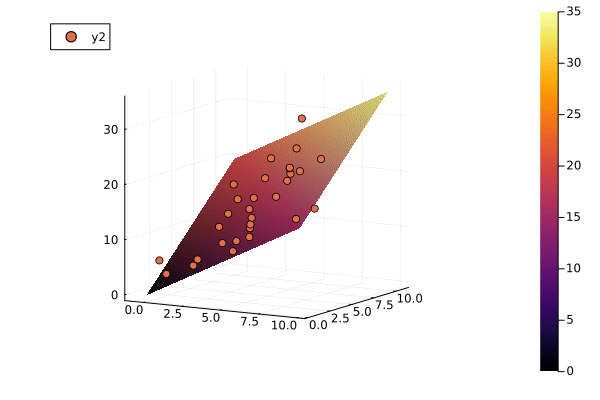

In [16]:
using Plots

xs = [0, 10]
ys = [0, 10]
d(p1, p2) = noisy_datagen_params.weights[1, :]' * [p1, p2]

print(d.(xs', ys))

plt = surface(xs, ys, d.(xs', ys))
scatter3d!(phi1, phi2, predicted_demand1)

anim = @animate for i in vcat(30:100, 100:-1:30)
    plot!(plt, camera = (i, 10))
end

gif(anim, "animsurf.gif", fps = 15)